In [105]:
%matplotlib widget
from kedro.io import DataCatalog
from kedro.extras.datasets.pandas import CSVDataSet
import h5py
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks
import hrvanalysis as hrva
from joblib import Parallel, delayed
import statistics as st
import sympy as sym
from sklearn.metrics import mean_squared_error

In [6]:
data_catalog = CSVDataSet(filepath="../data/01_raw/catalog.csv",
                        load_args={"sep": ';'})
io = DataCatalog(data_sets={'data_catalog': data_catalog})

df = io.load("data_catalog")
df

,cell_line,compound,file_path,note
0,D5,NaN,210315/D5/2599,NaN
1,PKP2-KO,NaN,210802/KO,NaN


In [7]:
df.loc[0,'file_path']

'210315/D5/2599'

In [16]:
# list all files in the directory
df2 = pd.DataFrame(columns=df.columns.to_list() + ['file_path_full'])
base_dir = "/mnt/z/recordings/Mea1k/leejih/"

for i in range(2):#len(df)):
    rec_files = glob.glob(base_dir+df.loc[i,'file_path']+'/*.h5')
    try:
        tmp = pd.concat([df.loc[[i]]]*len(rec_files), ignore_index=True)
        tmp["file_path_full"] = rec_files
        df2 = df2.merge(tmp, how='outer')
    except Exception as e:
        print(e)
df2

,cell_line,compound,file_path,note,file_path_full
0,D5,NaN,210315/D5/2599,NaN,/mnt/z/recordings/Mea1k/leejih/210315/D5/2599/...
1,D5,NaN,210315/D5/2599,NaN,/mnt/z/recordings/Mea1k/leejih/210315/D5/2599/...
2,D5,NaN,210315/D5/2599,NaN,/mnt/z/recordings/Mea1k/leejih/210315/D5/2599/...
3,D5,NaN,210315/D5/2599,NaN,/mnt/z/recordings/Mea1k/leejih/210315/D5/2599/...
4,D5,NaN,210315/D5/2599,NaN,/mnt/z/recordings/Mea1k/leejih/210315/D5/2599/...
5,D5,NaN,210315/D5/2599,NaN,/mnt/z/recordings/Mea1k/leejih/210315/D5/2599/...
6,PKP2-WT,NaN,220908/WT,NaN,/mnt/z/recordings/Mea1k/leejih/220908/WT/3994....
7,PKP2-WT,NaN,220908/WT,NaN,/mnt/z/recordings/Mea1k/leejih/220908/WT/3997....
8,PKP2-WT,NaN,220908/WT,NaN,/mnt/z/recordings/Mea1k/leejih/220908/WT/4002....
9,PKP2-WT,NaN,220908/WT,NaN,/mnt/z/recordings/Mea1k/leejih/220908/WT/4003....


In [15]:
base_dir = "/mnt/z/recordings/Mea1k/leejih/"
rec_files = glob.glob(base_dir+df.loc[2,'file_path']+'/*.h5')
rec_files
try:
    tmp = pd.concat([df.loc[[0]]]*len(rec_files), ignore_index=True)
    tmp["file_path_full"] = rec_files
    tmp
except Exception as e:
    print(e)

No objects to concatenate


In [70]:
filepath = "../data/01_raw/overall1.raw.h5"

obj = h5py.File(filepath, mode='r')
lsb = obj['settings']['lsb'][0] * 1e6

gain = (obj['settings']['gain'][0]).astype(int)
if 'lsb' in obj['settings']:
    lsb = obj['settings']['lsb'][0] * 1e6
else:
    lsb = 3.3 / (1024 * gain) * 1e6

mapping = obj.get('mapping')
channels = np.array(mapping['channel'])
electrodes = np.array(mapping['electrode'])

# remove unused channels
routed_idxs = np.where(electrodes > -1)[0]

channel_ids = list(channels[routed_idxs])
electrode_ids = list(electrodes[routed_idxs])
num_channels = len(electrode_ids)
num_frames = len(obj.get('sig')[0,:])
x_locs = list(np.array(mapping['x'][routed_idxs]))
y_locs = list(np.array(mapping['y'][routed_idxs]))

In [34]:
start_frame = 0
length = 100000
signals = (obj.get('sig')[np.array(channel_ids),start_frame:start_frame+length] * lsb).astype('float32') 

/home/leej/miniconda3/envs/cardio-env/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:501: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


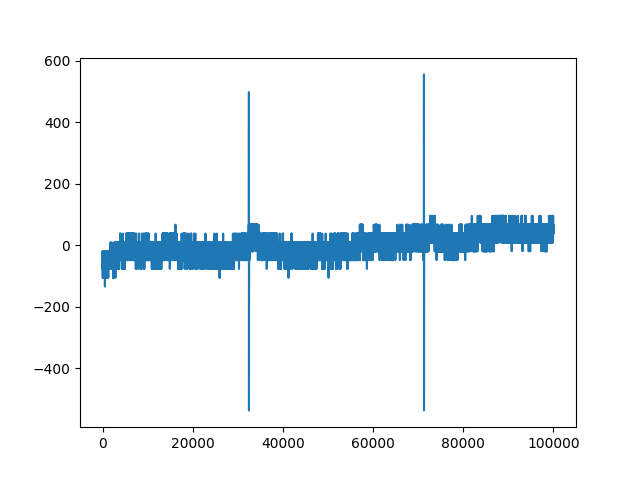

In [35]:
b, a = signal.butter(3,[100*2/2e4,2000*2/2e4],btype='band')
filt = signal.filtfilt(b, a, signals)

ch =8
fig, ax = plt.subplots()
ax.plot(signals[ch]-signals[ch].mean())
# ax.plot(abs(filt[ch]))

In [54]:
def _peakseek(data, minpeakdist, minpeakh):
    """Find peaks in a 1D array."""
    locs = np.where((data[1:-1] >= data[0:-2]) & (data[1:-1] >= data[2:]))[0] + 1
    
    if minpeakh:
        locs = locs[data[locs] > minpeakh]

    if minpeakdist > 1:
        while 1:
            multi = (locs[1:] - locs[0:-1]) < minpeakdist
            if not any(multi):
                break
            pks = data[locs]
            all_pks = np.array([[pks[i] for i in range(len(multi)) if multi[i]], [pks[i+1] for i in range(len(multi)) if multi[i]]])
            min_ind = np.argmin(all_pks,axis=0)

            multi_x = np.where(multi)[0]
            multi_xx = list(multi_x[min_ind==0]) + list(multi_x[min_ind==1] + 1)
            locs = np.delete(list(locs), multi_xx)
    pks = data[locs]
    
    return list(locs), pks

def _R_timestamps(signal_single,mult_factor,min_peak_dist):
    """Identify R peaks in a single channel."""
    thr = mult_factor*np.std(signal_single)
    r_locs, a = _peakseek(signal_single, minpeakdist=min_peak_dist, minpeakh=thr)

    return len(r_locs), r_locs

In [38]:
mult_factor = 5.5
min_peak_dist=4000
b, a = signal.butter(3,[100*2/2e4,2000*2/2e4],btype='band')
filtered = signal.filtfilt(b, a, signals) 
thr = mult_factor*np.std(filtered[0])
r_locs, _ = _peakseek(filtered[0], minpeakdist=min_peak_dist, minpeakh=thr)
r_locs

array([32459, 71282])

In [71]:
channelIDs = [ch for ch in range(len(signals))]
# Parallel processing using all available CPUs
res = Parallel(n_jobs=1, backend='multiprocessing')([delayed(_R_timestamps)(filtered[ch],mult_factor,min_peak_dist) for ch in channelIDs])
n_Rpeaks, r_timestamps = map(list,zip(*res))

# identify synchronous beats
sync_beats = st.mode(n_Rpeaks)
# indices of channels where beats (R peaks) are synchronous
ind_sync_channels = [ind for ind,peaks in enumerate(n_Rpeaks) if peaks==sync_beats]
sync_timestamps = [r_timestamps[i] for i in ind_sync_channels]
sync_channelIDs = [channelIDs[i] for i in ind_sync_channels]

x_locs_updated = [x_locs[i] for i in ind_sync_channels]
y_locs_updated = [y_locs[i] for i in ind_sync_channels]

In [ ]:
ch=8
signal_single = signals[ch]
thr = mult_factor*np.std(filtered[ch])
timestamps, _ = _peakseek(filtered[0], minpeakdist=min_peak_dist, minpeakh=thr)
before_R = 1000
after_R = 10000

waves = [signal_single[peak_loc-before_R:peak_loc+after_R] for peak_loc in timestamps if (peak_loc-before_R)>0 and (peak_loc+after_R)<=len(signal_single)] 
result = list(np.mean(np.vstack(waves),axis=0))

fig, ax = plt.subplots()
ax.plot(result)